<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/KNN_and_KNN_random_forest_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding, SpectralEmbedding


In [2]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation

Cloning into 'EEG-computation'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 422 (delta 37), reused 351 (delta 2), pack-reused 0
Receiving objects: 100% (422/422), 582.68 MiB | 47.84 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Checking out files: 100% (345/345), done.
/content/EEG-computation


In [0]:


disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])
    j = j+1
        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
    j = j+1   
        
data = {"N":channels_normal,
      "D":channels_disorder}



In [0]:
def New_Data_Generator_N():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['N'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['N'].append(new_data[person])
        person += 1

    
def New_Data_Generator_D():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['D'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['D'].append(new_data[person])
        person += 1

In [0]:
New_Data_Generator_N()
New_Data_Generator_D()

In [6]:
n_D , n_N = len(data['D']), len(data['N'])

n_D, n_N


(631, 567)

In [7]:
index = np.arange(0,512*30)
f = np.linspace(0,512,512*30)
f_max = f[len(f[f<120])]
ind_min = 2
ind_max = list(index[f==f_max])[0]
f_min = f[ind_min]

print(f_min, f_max, ind_min, ind_max)


sam_FT = np.abs(fft(data['D'][50][7]))

# The 50 Htz noise elimination information

f_45 = f>45
f_55 = f<55
f_bar = f<45

for i in range(f.shape[0]):
  f_bar[i] = f_45[i] and f_55[i]
  
  
noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
noise_index = list(index[f==noise])[0] # in range 0, 512*30
del_domain = 40
del_range = [noise_index + i for i in range(-del_domain,del_domain)]
print(noise, noise_index)

0.06667100722703301 120.00781300865941 2 3600
50.03659092388827 1501


In [8]:
sam_FT[list(f<55) or list(f>45)].shape

(1650,)

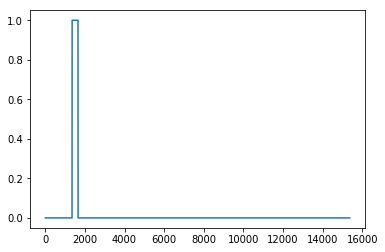

In [9]:


plt.plot(f_bar)



In [0]:


f = np.linspace(0,512,512*30)[ind_min:ind_max]



In [0]:
normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


FT = {'D':disorder,
     'N':normal}

from numpy.fft import fft

for d in range(n_D):
    for i in range(19):
        
        FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
        FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
        FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])
    
for n in range(n_N):
    for i in range(19):
        FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
        FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
        FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])
        

    FT['N'] = np.array(FT['N'])
    FT['D'] = np.array(FT['D'])

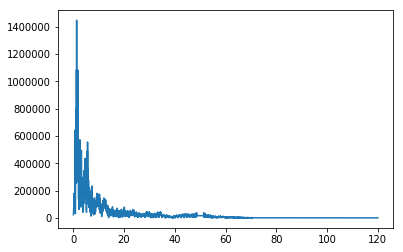

In [12]:


plt.plot(f, FT['N'][56][8])



In [0]:
FT_matrix_N = FT['N']
FT_matrix_D = FT['D']

temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
temp_N = FT_matrix_N.reshape((FT_matrix_N.shape[0],FT_matrix_N.shape[2],FT_matrix_N.shape[1]))
#or d in range(FT_matrix.shape[0]):
scaler = StandardScaler()

In [0]:
for n in range(FT_matrix_N.shape[0]):
  temp_N[n]= scaler.fit_transform(FT_matrix_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)


In [0]:


for n in range(FT_matrix_N.shape[0]):
  FT_matrix_N[n]= temp_N[n].T
  
for d in range(FT_matrix_D.shape[0]):
  FT_matrix_D[d]= temp_D[d].T



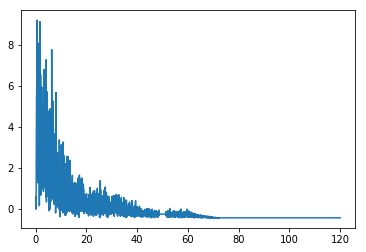

In [16]:
plt.plot(f,FT_matrix_D[8,8])

In [17]:
FT_matrix_D.shape, FT_matrix_N.shape

((631, 19, 3598), (567, 19, 3598))

In [0]:
# normal is 1 and disorder is 0
Data = np.vstack((FT_matrix_N, FT_matrix_D))
target = np.hstack((np.ones(FT_matrix_N.shape[0]), np.zeros(FT_matrix_D.shape[0])))

X, y = shuffle(Data, target)

In [0]:
pca = PCA(n_components = 0.95)
X = X.reshape(X.shape[0],-1)

In [20]:
X.shape


(1198, 68362)

In [0]:
X_pca = pca.fit_transform(X)

In [22]:
X_pca.shape

(1198, 756)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

In [0]:
y_pred = knn.predict(X_test)

In [0]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       158
         1.0       0.94      0.96      0.95       142

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



In [38]:
k_list = [ i for i in range(1,30) ]

for k in range(100):
  rand = int(np.random.random()*100)
  knn = KNeighborsClassifier(n_neighbors = rand)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  print(classification_report(y_pred, y_test))
  print(rand)

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       156
         1.0       0.90      0.90      0.90       144

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

91
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       157
         1.0       0.91      0.92      0.91       143

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300

77
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       160
         1.0       0.94      0.97      0.96       140

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

8
           

KeyboardInterrupt: ignored

In [37]:
int(np.random.random()*100)

91